# Natural Language Processing Introduction

In [6]:
import re
import string

import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.naive_bayes import MultinomialNB

np.set_printoptions(linewidth=140, precision=4, suppress=True)

%matplotlib inline

In [7]:
nltk.download("stopwords")
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/fabrizio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/fabrizio/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

### Text as data

Language is constantly being stored online through academic papers, books, news articles, speeches, social media, product reviews, etc... This "text data", whether spoken or written, is one of the main sources of data accessible online.

The ability to use and analyze this data would drastically increase the "data available" to data scientists, economists, and social scientists.

### What makes text difficult

However, textual data comes with one main difficulty: The methods that we've discussed in this class (and in your other classes) are meant to deal with numerical data.

In order to use text data (at scale) to gain insights into the world, we will need to find a way to transform the text data into numeric data. This transformation is difficult because language is a high dimensional object -- Words can have different meanings depending on how they are used and different combinations of words might map to the same meaning...

This transformation and the subsequent analysis "natural language processing".

### What we will learn today

* Tokenization
* Binary presence
* Bag of words

Additionally, we will introduce some new Python libraries including,

* `nltk` (Natural Language Toolkit)

We are going to learn these using two "fun" examples as motivation. In both examples, we will attempt to associate text with its authors:

1. [The Federalist Papers](https://en.wikipedia.org/wiki/The_Federalist_Papers) were a set of 85 articles written by Alexander Hamilton, James Madison, and John Jay under the pseudonym Publius. We have convincing evidence for who wrote a particular article for ~70 of the articles but the authorship of the other 15 is disputed. An early paper on NLP used classification methods to determine the author of the disputed articles. We view this as a "canonical" application of NLP.
2. Our other example will be in a similar vein. Dr. Sargent has written extensively about various topics with various coauthors. We will use the abstracts from some of these papers to determine whether we can determine who he coauthored a paper with given just the abstract. Classifying abstracts to various co-authors will be the simpler of the two tasks and we will use it as a chance to help us build the tools needed to tackle the Federalist example.

In [8]:
# We downloaded this DataFrame from the `corpus` R package. Big thanks to the
# authors of this package for making this easy!
federalist = pd.read_csv("federalist.csv", index_col=0)

federalist.head()

,name,title,venue,date,author,text
1,Federalist No. 1,General Introduction,For the Independent Journal,NaN,Hamilton,To the People of the State of New York:\n\nAFT...
2,Federalist No. 2,Concerning Dangers from Foreign Force and Infl...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nWHE...
3,Federalist No. 3,The Same Subject Continued (Concerning Dangers...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nIT ...
4,Federalist No. 4,The Same Subject Continued (Concerning Dangers...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nMY ...
5,Federalist No. 5,The Same Subject Continued (Concerning Dangers...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nQUE...


In [9]:
# Read in abstracts
def read_abstract_file(fn):
    author_abstract = []

    with open(fn) as f:
        foo = f.readlines()

        for line in foo:
            author, abstract = line.replace("\n", "").split(",", maxsplit=1)
            author_abstract.append((author, abstract))

    df = pd.DataFrame(
        author_abstract,
        columns=["coauthor", "abstract"]
    )
    return df

labeled_abstracts = read_abstract_file("../../Data/NLP/labeled_abstracts.csv")
unlabeled_abstracts = read_abstract_file("../../Data/NLP/unlabeled_abstracts.csv")

labeled_abstracts.head()

,coauthor,abstract
0,cogley,For a vector autoregression with drifting coef...
1,cogley,"For postwar U.S. data, this paper uses Bayesia..."
2,cogley,Previous studies have interpreted the rise and...
3,cogley,We estimate vector autoregressions with drifti...
4,hansen,A representative consumer uses Bayes' law to l...


### Skimming the abstracts

Can we by hand pick some themes in the research Dr. Sargent has done with his coauthors?

In [10]:
foo = labeled_abstracts.query("coauthor == 'ljungqvist'")["abstract"]

for (i, row) in foo.iteritems():
    print(row)
    print("\n")

A dispute about the size of the aggregate labor supply elasticity has been fortified by a contentious aggregation theory used by real business cycle theorists. The replacement of that aggregation theory with one more congenial to microeconomic observations opens possibilities for an accord about the aggregate labor supply elasticity. The new aggregation theory drops features to which empirical microeconomists objected and replaces them with life-cycle choices. Whether the new aggregation theory ultimately indicates a small or large macro labor supply elasticity will depend on how shocks and government institutions interact to put workers at interior solutions for career length.


To generate big responses of unemployment to productivity changes, researchers have reconfigured matching models in various ways: by elevating the utility of leisure, by making wages sticky, by assuming alternating-offer wage bargaining, by introducing costly acquisition of credit, or by positing government ma

## Tokenization

The process by which we "parse" text and convert it into a smaller set of "tokens". Today, we'll convert the text by using words as tokens and will occasionally refer to this set of tokens as our "vocabulary".

For example, consider the sentence,

>The quick brown fox jumps over the lazy dog

**Unigram**

One way we might "tokenize" this sentence would be to make each word its own token. This would give us the following tokens,

1. The
2. quick
3. brown
4. fox
5. jumps
6. over
7. the
8. lazy
9. dog

Our vocabulary would be 8 words with "the" appearing twice.

**Bigram**

Another way we might tokenize this sentence is to make each pair of words its own token. This would give us the following tokens

1. The quick
2. quick brown
3. brown fox
4. fox jumps
5. jumps over
6. over the
7. the lazy
8. lazy dog

Generically we refer to this type of tokenization as an _N-gram_. It is useful because it allows words like "very" to be more context dependent ("very good" vs "very bad") but comes at the cost of increasing the dimensionality of the words considered.

In practice unigram will typically work well for analysis as it keeps the vocabulary dimension small.

### Example

Consider the following paper abstracts,

>Ljungqvist and Sargent (1998, 2008) show that worse skill transition probabilities for workers who suffer involuntary layoffs (i.e., increases in turbulence) generate higher unemployment in a welfare state. den Haan, Haefke and Ramey (2005) challenge this finding by showing that if higher turbulence means that voluntary quits are also exposed to even a tiny risk of skill loss, then higher turbulence leads to lower unemployment within their matching model. We show (1) that there is no such brittleness of the positive turbulence-unemployment relationship in the matching model of Ljungqvist and Sargent (2007) even if we add such "quit turbulence", and (2) that if den Haan et al. had calibrated their productivity distribution to fit observed unemployment patterns that they miss, then they too would have found a positive turbulence-unemployment relationship in their model. Thus, we trace den Haan et al.'s finding to their assuming a narrower productivity distribution than Ljungqvist and Sargent had. Because den Haan et al. assume a distribution with such narrow support that it implies small returns to reallocating labor, even a small mobility cost shuts down voluntary separations. But that means that the imposition of a small layoff cost in tranquil times has counterfactually large unemployment suppression effects. When the parameterization is adjusted to fit historical observations on unemployment and layoff costs, a positive relationship between turbulence and unemployment reemerges.

>To understand trans-Atlantic employment experiences since World War II, we build an overlapping generations model with two types of workers (high school and college graduates) whose different skill acquisition technologies affect their career decisions. Search frictions affect short-run employment outcomes. The model focuses on labor supply responses near beginnings and ends of lives and on whether unemployment and early retirements are financed by personal savings or public benefit programs. Higher minimum wages in Europe explain why youth unemployment has risen more there than in the U.S. Turbulence, in the form of higher risks of human capital depreciation after involuntary job destructions, causes long-term unemployment in Europe, mostly among older workers, but leaves U.S. unemployment unaffected. The losses of skill interact with workers' subsequent decisions to invest in human capital in ways that generate the age-dependent increases in autocovariances of income shocks observed by Moffitt and Gottschalk (1995).

These are both drawn from papers coauthored by Lars Ljungqvist and Thomas Sargent. They are on similar topics so they share certain common words which should allow us to find some way to associate the two abstracts.

* What difficulties might there be in performing this association?

**Capitalization**

We typically normalize all text to be lower-case so that we don't generate unintended mismatches. For example, we would want to acknowledge that `turbulence` appears in both abstracts but is capitalized in the second.

**Contractions**

We will typically expand contractions into their full text meanings, i.e. "don't" -> "do not"

**Numbers**

Numbers without context in text don't always provide much useful information. For example, `(1)` and `(2)` would not help us understand what the abstract was about (and hence would not help us identify the author). On the other hand, there are contexts where the numbers are associated with years which might be helpful to us.

**Punctuation**

In a "fully-intelligent" context, punctuation might help the computer break ideas into sentences, but, for what we do today, we will remove punctuation.

One caveat to this is that there are many online contexts where subsets of punctuation marks can provide useful insights to what is being discussed -- For example, a tweet that contains `:-)` probably is a happy tweet whereas a tweet that contains `:-(` is likely a sad tweet.

**Plural, prefixes/suffixes, verb conjugation/tense...**

Certain words that we might want to be associated with one another seem to appear in multiple ways. For example,

* `risk`, `risks`
* `employment`, `unemployment`
* `had`, `have`

**Stop words**

For many applications, common words such as `the`, `and`, and other similar words to not provide much information about what is being discussed. We often will remove these words to cut down the number of words in our "vocabulary".

### Normalization

We discuss a few ways to address some of the issues we raised above.

We want to emphasize that different normalization methods are useful for different contexts. Blindly applying all of these normalization methods is likely to lead to a suboptimal result as you begin to analyze the data.

In [11]:
test_abstract = labeled_abstracts.loc[11, "abstract"]
print(test_abstract)

Ljungqvist and Sargent (1998, 2008) show that worse skill transition probabilities for workers who suffer involuntary layoffs (i.e., increases in turbulence) generate higher unemployment in a welfare state. den Haan, Haefke and Ramey (2005) challenge this finding by showing that if higher turbulence means that voluntary quits are also exposed to even a tiny risk of skill loss, then higher turbulence leads to lower unemployment within their matching model. We show (1) that there is no such brittleness of the positive turbulence-unemployment relationship in the matching model of Ljungqvist and Sargent (2007) even if we add such "quit turbulence", and (2) that if den Haan et al. had calibrated their productivity distribution to fit observed unemployment patterns that they miss, then they too would have found a positive turbulence-unemployment relationship in their model. Thus, we trace den Haan et al.'s finding to their assuming a narrower productivity distribution than Ljungqvist and Sar

#### Make text lowercase

In [12]:
test_abstract = test_abstract.lower()
print(test_abstract)

ljungqvist and sargent (1998, 2008) show that worse skill transition probabilities for workers who suffer involuntary layoffs (i.e., increases in turbulence) generate higher unemployment in a welfare state. den haan, haefke and ramey (2005) challenge this finding by showing that if higher turbulence means that voluntary quits are also exposed to even a tiny risk of skill loss, then higher turbulence leads to lower unemployment within their matching model. we show (1) that there is no such brittleness of the positive turbulence-unemployment relationship in the matching model of ljungqvist and sargent (2007) even if we add such "quit turbulence", and (2) that if den haan et al. had calibrated their productivity distribution to fit observed unemployment patterns that they miss, then they too would have found a positive turbulence-unemployment relationship in their model. thus, we trace den haan et al.'s finding to their assuming a narrower productivity distribution than ljungqvist and sar

#### Remove numbers and punctuation

In [13]:
test_abstract = test_abstract.replace("-", " ")

# I hadn't used `translate` before! Cool!
test_abstract = test_abstract.translate(
    str.maketrans("", "", string.digits + string.punctuation)
)

print(test_abstract)

ljungqvist and sargent   show that worse skill transition probabilities for workers who suffer involuntary layoffs ie increases in turbulence generate higher unemployment in a welfare state den haan haefke and ramey  challenge this finding by showing that if higher turbulence means that voluntary quits are also exposed to even a tiny risk of skill loss then higher turbulence leads to lower unemployment within their matching model we show  that there is no such brittleness of the positive turbulence unemployment relationship in the matching model of ljungqvist and sargent  even if we add such quit turbulence and  that if den haan et al had calibrated their productivity distribution to fit observed unemployment patterns that they miss then they too would have found a positive turbulence unemployment relationship in their model thus we trace den haan et als finding to their assuming a narrower productivity distribution than ljungqvist and sargent had because den haan et al assume a distri

#### Lemmatization vs Stemming

In order to compare versions of similar words, we can use one of two methods:

* Lemmatization: Processes the sentence using vocabulary and converts words into their base form (the "lemma").
* Stemming: A crude set of heuristics that chops off the ends of words in the hope of achieving the goal some of the time.

In [14]:
pstem = PorterStemmer()

print(" ".join(list(map(pstem.stem, test_abstract.split(" ")))))

ljungqvist and sargent   show that wors skill transit probabl for worker who suffer involuntari layoff ie increas in turbul gener higher unemploy in a welfar state den haan haefk and ramey  challeng thi find by show that if higher turbul mean that voluntari quit are also expos to even a tini risk of skill loss then higher turbul lead to lower unemploy within their match model we show  that there is no such brittl of the posit turbul unemploy relationship in the match model of ljungqvist and sargent  even if we add such quit turbul and  that if den haan et al had calibr their product distribut to fit observ unemploy pattern that they miss then they too would have found a posit turbul unemploy relationship in their model thu we trace den haan et al find to their assum a narrow product distribut than ljungqvist and sargent had becaus den haan et al assum a distribut with such narrow support that it impli small return to realloc labor even a small mobil cost shut down voluntari separ but t

In [15]:
lemm = WordNetLemmatizer()

test_abstract = " ".join(
    map(lemm.lemmatize, test_abstract.split(" "))
)
print(test_abstract)

ljungqvist and sargent   show that worse skill transition probability for worker who suffer involuntary layoff ie increase in turbulence generate higher unemployment in a welfare state den haan haefke and ramey  challenge this finding by showing that if higher turbulence mean that voluntary quits are also exposed to even a tiny risk of skill loss then higher turbulence lead to lower unemployment within their matching model we show  that there is no such brittleness of the positive turbulence unemployment relationship in the matching model of ljungqvist and sargent  even if we add such quit turbulence and  that if den haan et al had calibrated their productivity distribution to fit observed unemployment pattern that they miss then they too would have found a positive turbulence unemployment relationship in their model thus we trace den haan et al finding to their assuming a narrower productivity distribution than ljungqvist and sargent had because den haan et al assume a distribution wi

#### Remove stopwords

In [16]:
def remove_stopwords(text):

    # Get list of stopwords
    sw = stopwords.words("english")
    # Allocate space for all of our words
    out = []

    for word in text.split(" "):
        if word not in sw:
            out.append(word)

    return " ".join(out)

print(remove_stopwords(test_abstract))

ljungqvist sargent   show worse skill transition probability worker suffer involuntary layoff ie increase turbulence generate higher unemployment welfare state den haan haefke ramey  challenge finding showing higher turbulence mean voluntary quits also exposed even tiny risk skill loss higher turbulence lead lower unemployment within matching model show  brittleness positive turbulence unemployment relationship matching model ljungqvist sargent  even add quit turbulence  den haan et al calibrated productivity distribution fit observed unemployment pattern miss would found positive turbulence unemployment relationship model thus trace den haan et al finding assuming narrower productivity distribution ljungqvist sargent den haan et al assume distribution narrow support implies small return reallocating labor even small mobility cost shuts voluntary separation mean imposition small layoff cost tranquil time ha counterfactually large unemployment suppression effect parameterization adjuste

### Normalizing all abstracts

In [17]:
def normalizer(text):
    # First, set all text to lowercase
    text = text.lower()

    # Now remove punctuation and numbers
    text = text.replace("-", " ")
    text = text.translate(
        str.maketrans("", "", string.digits + string.punctuation)
    )

    # Remove anywhere with more than two consecutive whitespaces
    text = re.sub("\s\s+", " ", text)

    # Lemmatize words
    lemm = WordNetLemmatizer()
    text = " ".join(
        map(lemm.lemmatize, text.split(" "))
    )

    # Remove stopwords
    sw = stopwords.words("english")
    out = []

    for word in text.split(" "):
        if word not in sw:
            out.append(word)

    return " ".join(out)

labeled_abstracts["clean_abstract"] = labeled_abstracts["abstract"].map(normalizer)
unlabeled_abstracts["clean_abstract"] = unlabeled_abstracts["abstract"].map(normalizer)
labeled_abstracts.head()

,coauthor,abstract,clean_abstract
0,cogley,For a vector autoregression with drifting coef...,vector autoregression drifting coefficient sto...
1,cogley,"For postwar U.S. data, this paper uses Bayesia...",postwar u data paper us bayesian method accoun...
2,cogley,Previous studies have interpreted the rise and...,previous study interpreted rise fall u inflati...
3,cogley,We estimate vector autoregressions with drifti...,estimate vector autoregressions drifting coeff...
4,hansen,A representative consumer uses Bayes' law to l...,representative consumer us bayes law learn par...


## Binary presence

Once we've tokenized our data, we must choose a way to convert our tokens into numeric data. The simplest way to do this is simply categorize whether or not a value was present in the text or not.

Imagine that our vocabulary is `["quick", "brown", "fox", "red", "dog", "Clifford"]` then the sentence "The quick brown fox jumps over the lazy brown dog" would get converted to numeric data by placing a 1 for each vocabulary word that matches any token in the tokenized data. This would result in `[1, 1, 1, 0, 1, 0]`

Even though the word `"brown"` showed up multiple times, it just gets labeled as a 1 because we are just testing for the presence of certain words.

In [18]:
def binary_presence(vocabulary, text):
    # Allocate memory
    out = np.zeros(len(vocabulary), dtype=int)

    # Check whether the word is in our text
    for (iv, v) in enumerate(vocabulary):
        out[iv] = 1 if v in text else 0

    return out

# Build our test vocabulary
vocabulary = ["quick", "brown", "fox", "red", "dog", "Clifford"]
text = "the quick brown fox jumps over the lazy brown dog"

# Check whether this lines up with expected result
binary_presence(vocabulary, text)

array([1, 1, 1, 0, 1, 0])

### Choosing vocabulary

Binary presence seems easy enough to implement! However, we are left with one remaining detail... How do we choose a vocabulary?

One choice is to take _ALL_ words possible, but that will leave us with many words that might add a limited amount of information.

The way that we will do it in this example is to find all of the words that show up in at least 3 abstracts. We have at least 4 abstracts from a paper written with each coauthor so words that are used frequently in abstracts with particular coauthors should show if we count words that are in 3 abstracts.

Ultimately, the way that you build your vocabulary will be up to you (and be usage dependent!).

In [19]:
# Start with all words
all_words = list(
    set(
        labeled_abstracts["clean_abstract"].map(
            lambda x: x.split(" ")
        ).sum()
    )
)
all_words.sort()

# Count the number of times each word shows up
# in an abstract
out = np.zeros(len(all_words), dtype=bool)
for (iw, word) in enumerate(all_words):
    count_abstracts = (
        labeled_abstracts["clean_abstract"]
        .str
        .contains(word)
        .sum()
    )
    out[iw] = count_abstracts >= 3
    
abstract_vocabulary = [
    word for (iw, word) in enumerate(all_words) if out[iw]
]

### Naive Bayesian classification

Our favorite law (Bayes law) shows up again! We want to classify whether an abstract was written with a particular coauthor given which words from our vocabulary show up in the abstract.

Let $y_j$ denote each coauthor (Tim Cogley, Lars Hansen, or Lars Ljungqvist) and $x_i$ denote whether or not each word from the vocabulary appeared in the abstract, then:

$$P(y_j | x_1, x_2, \dots, x_n) = \frac{P(y) P(x_1, x_2, \dots, x_n | y_j)}{P(x_1, x_2, \dots, x_n)}$$


**Why "naive"?**

We refer to this classification method as "naive" because we assume that, given the coauthor that the probability of observing each word is independent to the others.

$$P(x_1, x_2, \dots, x_n | y_j) = P(x_1 | y_j) P(x_2 | y_j) \dots P(x_n | y_j)$$

There is no basis for this assumption and is simply made to simplify the mathematics. In fact, we could probably argue that this is a bad assumption for our data, but, in spite of this, it will prove to be successful!

**Parameter estimation**

We will assume that an abstract is equally likely to have been written by each coauthor, i.e., $P(y_j) = P(y_k) = \frac{1}{3}$

The probabilities $P(x_i | y_j)$ are computed by using something similar to a beta-binomial conjugate prior (but allows for more than 2 classes).

**Preparing the data**

In [20]:
nobs = labeled_abstracts.shape[0]
nwords = len(abstract_vocabulary)

coauthors = {
    "cogley": 0,
    "hansen": 1,
    "ljungqvist": 2
}

X = np.zeros((nobs, nwords), dtype=int)
y = np.zeros(nobs, dtype=int)

for i in range(nobs):
    y[i] = coauthors[labeled_abstracts.at[i, "coauthor"]]

    for (j, word) in enumerate(abstract_vocabulary):
        X[i, j] = word in labeled_abstracts.at[i, "clean_abstract"]


**Estimate using sklearn**

In [21]:
mnb = MultinomialNB(fit_prior=False)

mnb.fit(X, y)

MultinomialNB(fit_prior=False)

**Can we predict who the remaining abstracts were written with?**

In [22]:
for (i, ab) in unlabeled_abstracts["abstract"].iteritems():
    print(ab)
    print("\n")

We estimate a Bayesian vector autoregression for the U.K. with drifting coefficients and stochastic volatilities. We use it to characterize posterior densities for several objects that are useful for designing and evaluating monetary policy, including local approximations to the mean, persistence, and volatility of inflation. We present diverse sources of uncertainty that impinge on the posterior predictive density for inflation, including model uncertainty, policy drift, structural shifts and other shocks. We use a recently developed minimum entropy method to bring outside information to bear on inflation forecasts. We compare our predictive densities with the Bank of England's fan charts.


An ambiguity averse decision maker evaluates plans under a restricted family of structured models and unstructured alternatives that are statistically close to them. Structured models include parametric models in which parameter values vary over time in ways that the decision maker cannot describe

In [23]:
noos = unlabeled_abstracts.shape[0]

X_oos = np.zeros((noos, nwords), dtype=int)
y_oos = np.zeros(noos, dtype=int)

for i in range(noos):
    y_oos[i] = coauthors[unlabeled_abstracts.at[i, "coauthor"]]

    for (j, word) in enumerate(abstract_vocabulary):
        X_oos[i, j] = word in unlabeled_abstracts.at[i, "clean_abstract"]


In [24]:
mnb.predict(X_oos)

array([0, 1, 1, 2, 2, 2])

In [25]:
y_oos

array([0, 1, 1, 2, 2, 0])

In [26]:
mnb.predict_proba(X_oos)

array([[0.9974, 0.0025, 0.0001],
       [0.0002, 0.9962, 0.0036],
       [0.0023, 0.9939, 0.0037],
       [0.0216, 0.0358, 0.9426],
       [0.0029, 0.0021, 0.995 ],
       [0.0766, 0.2118, 0.7116]])

## Bag of words

[Bag of words](https://en.wikipedia.org/wiki/Bag-of-words_model) will be similar to binary presence, but, rather than simple track whether a word shows up in the text, we will count the number of times it shows up.

The "implicit assumption" in bag of words models is that words are drawn from an urn with certain probabilities and that order is unimportant.

We revisit our example from before:

Imagine that our vocabulary is `["quick", "brown", "fox", "red", "dog", "Clifford"]` then the sentence "The quick brown fox jumps over the lazy brown dog" would get converted to numeric data by counting the number of times each vocabulary word appears in the tokenized data. This would result in `[1, 2, 1, 0, 1, 0]`

Before, we placed a 1 in the vector element that corresponded to brown, but since we are now counting occurrences, we place a 2.

In [27]:
def bag_of_words(vocabulary, text):
    # Check whether the word is in our text
    dcount = {word: 0 for word in vocabulary}
    for word in text.split(" "):
        if word in vocabulary:
            dcount[word] += 1

    out = np.array([dcount[word] for word in vocabulary])

    return out

# Build our test vocabulary
vocabulary = ["quick", "brown", "fox", "red", "dog", "Clifford"]
text = "the quick brown fox jumps over the lazy brown dog"

# Check whether this lines up with expected result
bag_of_words(vocabulary, text)

array([1, 2, 1, 0, 1, 0])

### Choosing vocabulary

We must again consider how to choose our vocabulary. The Federalist papers were all written on a similar topic, so many of the words will be shared across the documents (one of the reasons why binary presence will not perform particularly well in this case).

Rather than target the "topic" covered in each document, we will attempt to extract information on the writing style by tracking the way certain words are used. In the original paper, Mosteller and Wallace choose 30 (relatively common) words that they think can proxy for each of the individual authors' writing styles. They call these words "markers" and they highlight that Hamilton and Madison use words differently. For example, In the 14 essays written by Madison, the word _while_ never occurs but _whilst_ occurs in 8 of them. Similarly, _while_ occurs in 15 of the 48 Hamilton essays, but _whist_ never occurs. 


In [28]:
federalist_vocabulary = [
    "upon", "also", "an", "by", "of", "on", "there", "this", "to",
    "although", "both", "enough", "while", "whilst", "always", "though",
    "commonly", "consequently", "considerable", "according", "apt",
    "direction", "innovation", "language", "vigor", "kind", "matter",
    "particularly", "probability", "work"
]

### Normalizing the data

Given that our goals are slightly different this time, our normalization procedure will look slightly different.

In particular, we will _not_ want to remove stopwords because many of the vocabularly words that we're using to identify the styles are stopwords.

We will also directly replace some of the various tenses of words rather than use a lemmatizer or stemmer.

In [29]:
def normalizer_federalist(text):
    # First, set all text to lowercase
    text = text.lower()

    # Now remove punctuation and numbers
    text = text.translate(
        str.maketrans("", "", string.digits + string.punctuation)
    )

    # Remove anywhere with more than two consecutive whitespaces
    text = re.sub("\n", " ", text)
    text = re.sub("\s\s+", " ", text)

    # Replace certain words
    replacer = [
        ("matters", "matter"),
        ("considerably", "considerable"),
        ("innovations", "innovation"),
        ("vigorous", "vigor"),
        ("works", "work")
    ]
    for (_w, _r) in replacer:
        text.replace(_w, _r)

    return text

federalist["clean_text"] = federalist["text"].map(
    normalizer_federalist
)

federalist.head()

,name,title,venue,date,author,text,clean_text
1,Federalist No. 1,General Introduction,For the Independent Journal,NaN,Hamilton,To the People of the State of New York:\n\nAFT...,to the people of the state of new york after a...
2,Federalist No. 2,Concerning Dangers from Foreign Force and Infl...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nWHE...,to the people of the state of new york when th...
3,Federalist No. 3,The Same Subject Continued (Concerning Dangers...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nIT ...,to the people of the state of new york it is n...
4,Federalist No. 4,The Same Subject Continued (Concerning Dangers...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nMY ...,to the people of the state of new york my last...
5,Federalist No. 5,The Same Subject Continued (Concerning Dangers...,For the Independent Journal,NaN,Jay,To the People of the State of New York:\n\nQUE...,to the people of the state of new york queen a...


Additionally, rather than keep the counts directly, we will convert the counts to a rate per 100,000 words and round to the nearest integer. We do this to make sure that the documents are comparable in spite of differing in length. We convert to integers because our naive Bayes classifier assumes that the inputs are integers.

In [30]:
federalist["nwords"] = federalist["clean_text"].str.split(" ").map(lambda x: len(x))

**Preparing the data**

In [31]:
# Separate into known and unknown authors
known_federalist = (
    federalist
    .loc[~federalist["author"].isna(), :]
    .reset_index(drop=True)
)
unknown_federalist = (
    federalist
    .loc[federalist["author"].isna(), :]
    .reset_index(drop=True)
)

nobs = known_federalist.shape[0]
nvocab = len(federalist_vocabulary)

publius = {
    "Hamilton": 0,
    "Jay": 1,
    "Madison": 2
}

X = np.zeros((nobs, nvocab), dtype=int)
y = np.zeros(nobs, dtype=int)

for i in range(nobs):
    y[i] = publius[known_federalist.at[i, "author"]]
    X[i, :] = bag_of_words(
        federalist_vocabulary,
        known_federalist.at[i, "clean_text"]
    )

# Convert to rates
nwords = known_federalist.loc[:, "nwords"].to_numpy()
X = np.round(100_000 * X/nwords[:, None]).astype(int)


**Estimate with sklearn**

In [32]:
mnb = MultinomialNB(fit_prior=False)

mnb.fit(X, y)

MultinomialNB(fit_prior=False)

**Predict unknown authors**

In [33]:
noos = unknown_federalist.shape[0]

X_oos = np.zeros((noos, nvocab), dtype=int)

for i in range(noos):
    X_oos[i, :] = bag_of_words(
        federalist_vocabulary,
        unknown_federalist.at[i, "clean_text"]
    )

# Convert to rates
nwords = unknown_federalist.loc[:, "nwords"].to_numpy()
X_oos = np.round(100_000 * X_oos/nwords[:, None]).astype(int)

probs_oos = mnb.predict_proba(X_oos)

In [34]:
idx_h = known_federalist.query("author == 'Hamilton'").index
wpht_h = X[idx_h, :].mean(axis=0)

idx_m = known_federalist.query("author == 'Madison'").index
wpht_m = X[idx_m, :].mean(axis=0)

(0.0, 500.0)

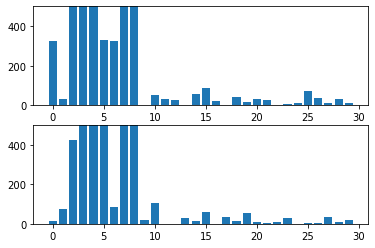

In [35]:
fig, ax = plt.subplots(2)

ax[0].bar(np.arange(nvocab), wpht_h)
ax[0].set_ylim(0, 500)

ax[1].bar(np.arange(nvocab), wpht_m)
ax[1].set_ylim(0, 500)

In [36]:
federalist_vocabulary[0]

'upon'

In [37]:
probs_oos

array([[0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.],
       [0., 0., 1.]])

## References

* Business Data Science. Matt Taddy. (Chapter 8).
* Inference and Disputed Authorship: The Federalist. Mosteller, Frederick and Wallace, David L. https://www.jstor.org/stable/202633
* Updating: A Set of Bayesian Notes. Jeffrey B. Arnold. (Chapter 4). https://jrnold.github.io/bayesian_notes/index.html
